# Model #3 (Question #3)- K-Means Clustering: Airline Delay Patterns Do certain airline companies have more flight delays?

In [2]:
# K-Means Clustering – "Do certain airlines have more flight delays?"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Load dataset
path = "/content/AllData_Mergedfinal.csv"
df = pd.read_csv(path)

print("Shape:", df.shape)
display(df.head())
print("\nColumns:", df.columns.tolist())

Shape: (43853, 21)


,Carrier Code,Date (MM/DD/YYYY),Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),...,Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes),Delay Unknown (Minutes),Arrival Delay (Minutes),Total Delay (Minutes),Num of Delay Reasons,Primary Delay Reason,Primary Delay Percentage
0,B6,01/12/2024,JFK,17:50,18:08,164.0,212.0,18.0,19:14,66.0,...,18.0,48.0,0.0,0.0,0.0,48.0,66.0,2,Aviation System,0.727273
1,B6,01/24/2024,JFK,17:50,17:36,164.0,161.0,-14.0,17:48,12.0,...,0.0,0.0,0.0,0.0,0.0,-3.0,-17.0,0,No Reason,0.000000
2,B6,02/12/2024,JFK,17:50,00:00,164.0,0.0,0.0,00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,-164.0,-164.0,0,No Reason,0.000000
3,B6,02/24/2024,JFK,16:43,16:35,166.0,171.0,-8.0,16:51,16.0,...,0.0,0.0,0.0,0.0,0.0,5.0,-3.0,0,No Reason,0.000000
4,B6,03/12/2024,JFK,16:56,17:09,169.0,164.0,13.0,17:22,13.0,...,0.0,0.0,0.0,0.0,8.0,-5.0,8.0,1,Unknown,1.000000



Columns: ['Carrier Code', 'Date (MM/DD/YYYY)', 'Destination Airport', 'Scheduled departure time', 'Actual departure time', 'Scheduled elapsed time (Minutes)', 'Actual elapsed time (Minutes)', 'Departure delay (Minutes)', 'Wheels-off time', 'Taxi-Out time (Minutes)', 'Delay Carrier (Minutes)', 'Delay Weather (Minutes)', 'Delay National Aviation System (Minutes)', 'Delay Security (Minutes)', 'Delay Late Aircraft Arrival (Minutes)', 'Delay Unknown (Minutes)', 'Arrival Delay (Minutes)', 'Total Delay (Minutes)', 'Num of Delay Reasons', 'Primary Delay Reason', 'Primary Delay Percentage']


In [3]:
cols = [
    "Carrier Code", "Date (MM/DD/YYYY)", "Destination Airport",
    "Scheduled departure time", "Actual departure time",
    "Departure delay (Minutes)", "Arrival Delay (Minutes)"
]

subset = df[cols].head()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('off')
table = ax.table(cellText=subset.values, colLabels=subset.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.6)

plt.savefig("raw_dataset_preview.png", bbox_inches='tight')
plt.close()

In [4]:
from google.colab import files
files.download("raw_dataset_preview.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# Assign columns
airline_col = "Carrier Code"
depdelay_col = "Departure delay (Minutes)"
arrdelay_col = "Arrival Delay (Minutes)"

# Clean
df[depdelay_col] = pd.to_numeric(df[depdelay_col], errors='coerce')
df[arrdelay_col] = pd.to_numeric(df[arrdelay_col], errors='coerce')

# Replace negative delays with 0 (early flights)
df["DelayMinutes_Pos"] = df[depdelay_col].clip(lower=0)

# Create delay flags
df["IsDelayed_15"] = (df[depdelay_col] >= 15).astype(int)
df["IsDelayed_60"] = (df[depdelay_col] >= 60).astype(int)

# Group by airline
agg = df.groupby(airline_col).agg(
    flights=("IsDelayed_15", "size"),
    delay_rate_15=("IsDelayed_15", "mean"),
    delay_rate_60=("IsDelayed_60", "mean"),
    avg_delay=("DelayMinutes_Pos", "mean"),
    p95_delay=("DelayMinutes_Pos", lambda x: np.percentile(x, 95))
)


In [6]:
# Drop airlines with too few flights to be meaningful
agg = agg[agg["flights"] >= 50].copy()

# Add a log scale for flight count
agg["log_flights"] = np.log1p(agg["flights"])

print("\nAggregated airline-level data:")
display(agg)

# Prepare features for clustering
features = ["delay_rate_15", "delay_rate_60", "avg_delay", "p95_delay", "log_flights"]
X = agg[features].fillna(0.0)

print("\nFeature snapshot BEFORE scaling:")
display(X.head())


Aggregated airline-level data:


,flights,delay_rate_15,delay_rate_60,avg_delay,p95_delay,log_flights
Carrier Code,,,,,,
AA,5398,0.258800,0.121156,24.844572,133.00,8.593969
AS,401,0.204489,0.039900,10.471322,45.00,5.996452
B6,801,0.249688,0.129838,20.548065,112.00,6.687109
DL,3854,0.179035,0.065906,14.018941,76.00,8.257126
F9,1973,0.291434,0.110492,21.184491,107.40,7.587817
NK,1212,0.238449,0.105611,17.834983,99.00,7.100852
OO,7792,0.169405,0.065195,13.953542,74.45,8.960981
UA,13372,0.181349,0.075531,14.374140,84.00,9.500993
WN,9050,0.244420,0.048177,12.792376,58.00,9.110631



Feature snapshot BEFORE scaling:


,delay_rate_15,delay_rate_60,avg_delay,p95_delay,log_flights
Carrier Code,,,,,
AA,0.258800,0.121156,24.844572,133.0,8.593969
AS,0.204489,0.039900,10.471322,45.0,5.996452
B6,0.249688,0.129838,20.548065,112.0,6.687109
DL,0.179035,0.065906,14.018941,76.0,8.257126
F9,0.291434,0.110492,21.184491,107.4,7.587817



Feature snapshot AFTER scaling:


,delay_rate_15,delay_rate_60,avg_delay,p95_delay,log_flights
Carrier Code,,,,,
AA,0.871690,1.179236,1.844868,1.729251,0.544557
AS,-0.493388,-1.445167,-1.398607,-1.626297,-1.749305
B6,0.642672,1.459639,0.875316,0.928496,-1.139388
DL,-1.133164,-0.605246,-0.598049,-0.444229,0.247091
F9,1.691952,0.834798,1.018932,0.753092,-0.343974


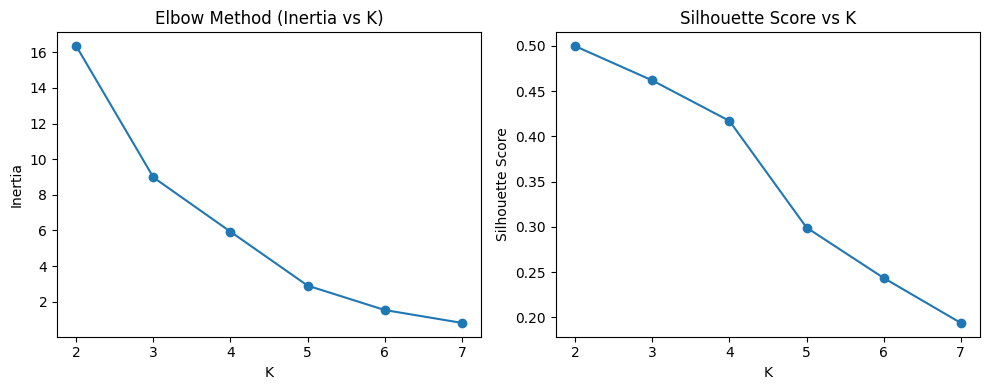


Best K (by Silhouette): 2


In [7]:
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nFeature snapshot AFTER scaling:")
display(pd.DataFrame(X_scaled[:5], columns=features, index=agg.index[:5]))

# Determine optimal K (Elbow + Silhouette)
inertias, silhouettes = [], []
K_range = range(2, 8)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method (Inertia vs K)")
plt.xlabel("K")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K_range, silhouettes, marker='o')
plt.title("Silhouette Score vs K")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

best_k = K_range[np.argmax(silhouettes)]
print(f"\nBest K (by Silhouette): {best_k}")

Data Formatting:
To prepare the dataset for K-Means clustering, preprocessing steps were applied to make the data compatible with the algorithm and enable fair airline comparisons. Flight-level records were first cleaned by converting delay fields to numeric values and clipping negative delays (early departures) to zero, followed by creating binary indicators for moderate (≥15 min) and severe (≥60 min) delays. Because the research question focuses on differences between airlines rather than individual flights, data was aggregated by carrier to compute total flights, delay rates, mean positive delay minutes, and the 95th percentile delay duration, while removing airlines with fewer than 50 observations. To prevent high-volume airlines from dominating cluster formation, flight count was log-transformed, and the final feature set—delay_rate_15, delay_rate_60, avg_delay, p95_delay, and log_flights—was standardized using StandardScaler so all variables contributed proportionally to the Euclidean distance calculations used by K-Means.


Silhouette Score: 0.500
Davies-Bouldin Index: 0.687

Cluster profiles (average delay behavior):


,delay_rate_15,delay_rate_60,avg_delay,p95_delay,log_flights
Cluster,,,,,
1,0.259593,0.116774,21.103028,112.85,7.492437
0,0.195739,0.058942,13.122064,67.49,8.365237



Top airlines in Cluster 0:


,flights,delay_rate_15,delay_rate_60,avg_delay,p95_delay,log_flights,Cluster
Carrier Code,,,,,,,
WN,9050,0.244420,0.048177,12.792376,58.00,9.110631,0
AS,401,0.204489,0.039900,10.471322,45.00,5.996452,0
UA,13372,0.181349,0.075531,14.374140,84.00,9.500993,0
DL,3854,0.179035,0.065906,14.018941,76.00,8.257126,0
OO,7792,0.169405,0.065195,13.953542,74.45,8.960981,0



Top airlines in Cluster 1:


,flights,delay_rate_15,delay_rate_60,avg_delay,p95_delay,log_flights,Cluster
Carrier Code,,,,,,,
F9,1973,0.291434,0.110492,21.184491,107.4,7.587817,1
AA,5398,0.258800,0.121156,24.844572,133.0,8.593969,1
B6,801,0.249688,0.129838,20.548065,112.0,6.687109,1
NK,1212,0.238449,0.105611,17.834983,99.0,7.100852,1


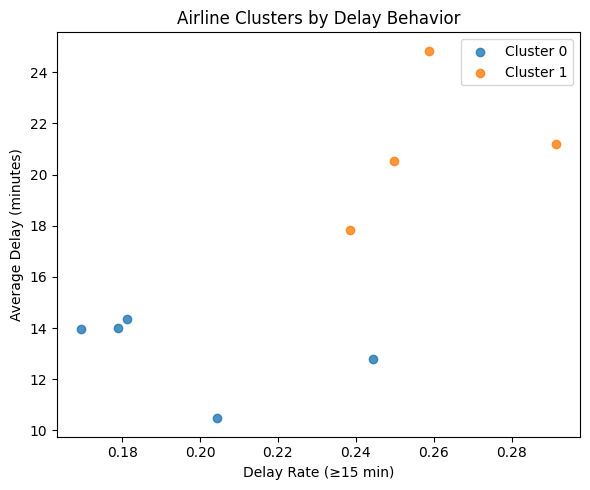

In [8]:
# Fit final K-Means model
kmeans_final = KMeans(n_clusters=best_k, n_init=20, random_state=42)
labels = kmeans_final.fit_predict(X_scaled)

agg["Cluster"] = labels

# Evaluate clustering
sil = silhouette_score(X_scaled, labels)
dbi = davies_bouldin_score(X_scaled, labels)
print(f"\nSilhouette Score: {sil:.3f}")
print(f"Davies-Bouldin Index: {dbi:.3f}")

# Cluster profiles
cluster_profiles = agg.groupby("Cluster")[features].mean().sort_values("delay_rate_15", ascending=False)
print("\nCluster profiles (average delay behavior):")
display(cluster_profiles)

# Airlines per cluster
for c in sorted(agg["Cluster"].unique()):
    print(f"\nTop airlines in Cluster {c}:")
    display(agg[agg["Cluster"] == c].sort_values("delay_rate_15", ascending=False).head(5))

# Visualization
plt.figure(figsize=(6,5))
for c in sorted(agg["Cluster"].unique()):
    sub = agg[agg["Cluster"] == c]
    plt.scatter(sub["delay_rate_15"], sub["avg_delay"], label=f"Cluster {c}", alpha=0.8)
plt.xlabel("Delay Rate (≥15 min)")
plt.ylabel("Average Delay (minutes)")
plt.title("Airline Clusters by Delay Behavior")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Final airline-cluster table
agg.reset_index(inplace=True)
display(agg[[airline_col, "Cluster", "delay_rate_15", "avg_delay", "flights"]].sort_values("Cluster"))


,Carrier Code,Cluster,delay_rate_15,avg_delay,flights
1,AS,0,0.204489,10.471322,401
3,DL,0,0.179035,14.018941,3854
6,OO,0,0.169405,13.953542,7792
7,UA,0,0.181349,14.374140,13372
8,WN,0,0.244420,12.792376,9050
2,B6,1,0.249688,20.548065,801
5,NK,1,0.238449,17.834983,1212
0,AA,1,0.258800,24.844572,5398
4,F9,1,0.291434,21.184491,1973


K-Means Clustering: Airline Delay Patterns

**Why the model was chosen:** K-Means was selected because it is an unsupervised learning algorithm that effectively groups airlines with similar delay characteristics using numerical features such as average delay time and percentage of delayed flights. The dataset contained continuous numeric variables (e.g., average delay, delay rate ≥15 minutes, and p95 delay), making K-Means suitable for finding natural clusters that distinguish on-time versus delay-prone carriers. Its efficiency and interpretability make it ideal for exploratory pattern discovery within airline performance data.

**Model assumptions:** K-Means assumes that clusters are approximately spherical in feature space and that data points are numerically scaled with similar variance. To meet these assumptions, all features were standardized using StandardScaler. It also assumes Euclidean distance is meaningful, which holds since the features (delay percentages and times) are continuous and comparable after scaling.

**Hyperparameter tuning:** The primary hyperparameter, number of clusters (K), was tuned using the Elbow method (Inertia vs. K) and the Silhouette Score. Both methods indicated an optimal K = 2, balancing compactness and separation (Silhouette = 0.500, Davies-Bouldin = 0.687).

* n_clusters: 2
* n_init: 20 (for stability)
* random_state: 42 (for reproducibility)

**Challenges faced & solutions:** A key challenge in clustering was that airlines operate at vastly different flight volumes, which risked skewing delay averages and allowing large carriers (such as United or Southwest) to dominate the cluster structure. To correct for this imbalance, we introduced a log-transformed flight count feature (log_flights) to normalize scale differences. A second challenge involved negative delay values, which represented early departures and distorted the true delay averages. To address this, we created a new adjusted feature, DelayMinutes_Pos, which clipped negative delay times to zero. These preprocessing steps produced more meaningful and comparable delay patterns across all airlines and improved clustering performance.

**Key Findings:**
* Cluster 0 (Low-delay airlines): AS, DL, OO, UA, and WN — lower average delays (≈13 min) and smaller delay rates (≈19%).
* Cluster 1 (High-delay airlines):
F9, AA, B6, and NK — higher average delays (≈21 min) and larger delay rates (≈26%).
This suggests two distinct airline behavior groups: one consistently on-time, and another experiencing frequent and longer delays, often associated with system congestion or operational inefficiencies.

**Performance Evaluation:** The performance of the K-Means model was evaluated using the Silhouette Score and the Davies-Bouldin Index. With K = 2, the model achieved a Silhouette Score of 0.500, indicating good cohesion within clusters and clear separation between them. The Davies-Bouldin Index of 0.687 further supports strong cluster quality, since lower values imply greater separation and less overlap. Together, these metrics confirm that K-Means effectively identified two meaningful airline performance groups: consistently on-time carriers vs. delay-prone carriers.

# Model #4: (Question #4)- K-Means Clustering: Airport Delay Patterns

In [10]:
# K-Means Clustering – "Do certain airports have more flight delays?"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# 1. Load dataset
path = "/content/AllData_Mergedfinal.csv"
df = pd.read_csv(path)

print("Shape:", df.shape)
display(df.head())

Shape: (43853, 21)


,Carrier Code,Date (MM/DD/YYYY),Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),...,Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes),Delay Unknown (Minutes),Arrival Delay (Minutes),Total Delay (Minutes),Num of Delay Reasons,Primary Delay Reason,Primary Delay Percentage
0,B6,01/12/2024,JFK,17:50,18:08,164.0,212.0,18.0,19:14,66.0,...,18.0,48.0,0.0,0.0,0.0,48.0,66.0,2,Aviation System,0.727273
1,B6,01/24/2024,JFK,17:50,17:36,164.0,161.0,-14.0,17:48,12.0,...,0.0,0.0,0.0,0.0,0.0,-3.0,-17.0,0,No Reason,0.000000
2,B6,02/12/2024,JFK,17:50,00:00,164.0,0.0,0.0,00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,-164.0,-164.0,0,No Reason,0.000000
3,B6,02/24/2024,JFK,16:43,16:35,166.0,171.0,-8.0,16:51,16.0,...,0.0,0.0,0.0,0.0,0.0,5.0,-3.0,0,No Reason,0.000000
4,B6,03/12/2024,JFK,16:56,17:09,169.0,164.0,13.0,17:22,13.0,...,0.0,0.0,0.0,0.0,8.0,-5.0,8.0,1,Unknown,1.000000


In [11]:
# Define key columns
airport_col = "Destination Airport"
depdelay_col = "Departure delay (Minutes)"
arrdelay_col = "Arrival Delay (Minutes)"

# Clean and preprocess
df[depdelay_col] = pd.to_numeric(df[depdelay_col], errors="coerce")
df[arrdelay_col] = pd.to_numeric(df[arrdelay_col], errors="coerce")

# Replace early departures with 0
df["DelayMinutes_Pos"] = df[depdelay_col].clip(lower=0)
df["IsDelayed_15"] = (df[depdelay_col] >= 15).astype(int)
df["IsDelayed_60"] = (df[depdelay_col] >= 60).astype(int)

# Aggregate delay metrics per airport
agg = df.groupby(airport_col).agg(
    flights=("IsDelayed_15", "size"),
    delay_rate_15=("IsDelayed_15", "mean"),
    delay_rate_60=("IsDelayed_60", "mean"),
    avg_delay=("DelayMinutes_Pos", "mean"),
    p95_delay=("DelayMinutes_Pos", lambda x: np.percentile(x, 95)),
    carrier_delay_mean=("Delay Carrier (Minutes)", "mean"),
    weather_delay_mean=("Delay Weather (Minutes)", "mean"),
    nas_delay_mean=("Delay National Aviation System (Minutes)", "mean"),
    late_aircraft_delay_mean=("Delay Late Aircraft Arrival (Minutes)", "mean"),
)

# Filter out small airports for stability
agg = agg[agg["flights"] >= 100].copy()
agg["log_flights"] = np.log1p(agg["flights"])

print("\nAggregated airport-level delay data:")
display(agg.head())


Aggregated airport-level delay data:


,flights,delay_rate_15,delay_rate_60,avg_delay,p95_delay,carrier_delay_mean,weather_delay_mean,nas_delay_mean,late_aircraft_delay_mean,log_flights
Destination Airport,,,,,,,,,,
ABQ,254,0.224409,0.039370,10.515748,47.00,2.468504,0.000000,0.885827,4.346457,5.541264
ASE,252,0.190476,0.059524,22.932540,76.45,3.936508,12.523810,0.948413,3.349206,5.533389
ATL,1500,0.205333,0.078667,15.322667,90.05,4.671333,0.283333,2.275333,6.542667,7.313887
ATW,133,0.195489,0.060150,12.503759,81.80,5.308271,0.000000,1.127820,4.285714,4.897840
AUS,540,0.198148,0.066667,14.727778,77.20,5.188889,0.111111,2.746296,5.938889,6.293419



Feature snapshot BEFORE scaling:


,delay_rate_15,delay_rate_60,avg_delay,p95_delay,carrier_delay_mean,weather_delay_mean,nas_delay_mean,late_aircraft_delay_mean,log_flights
Destination Airport,,,,,,,,,
ABQ,0.224409,0.039370,10.515748,47.00,2.468504,0.000000,0.885827,4.346457,5.541264
ASE,0.190476,0.059524,22.932540,76.45,3.936508,12.523810,0.948413,3.349206,5.533389
ATL,0.205333,0.078667,15.322667,90.05,4.671333,0.283333,2.275333,6.542667,7.313887
ATW,0.195489,0.060150,12.503759,81.80,5.308271,0.000000,1.127820,4.285714,4.897840
AUS,0.198148,0.066667,14.727778,77.20,5.188889,0.111111,2.746296,5.938889,6.293419



Feature snapshot AFTER scaling:


,delay_rate_15,delay_rate_60,avg_delay,p95_delay,carrier_delay_mean,weather_delay_mean,nas_delay_mean,late_aircraft_delay_mean,log_flights
Destination Airport,,,,,,,,,
ABQ,0.405916,-1.379091,-1.155135,-1.510922,-0.973926,-0.503774,-1.066245,-0.702991,-0.196003
ASE,-0.531398,-0.551080,1.812771,-0.122436,-0.325166,6.883762,-1.020710,-1.128768,-0.206165
ATL,-0.121010,0.235399,-0.006168,0.518767,-0.000423,-0.336641,-0.055296,0.234683,2.091586
ATW,-0.392941,-0.525338,-0.679954,0.129802,0.281061,-0.503774,-0.890181,-0.728925,-1.026348
AUS,-0.319481,-0.257618,-0.148361,-0.087075,0.228302,-0.438231,0.287358,-0.023101,0.774662


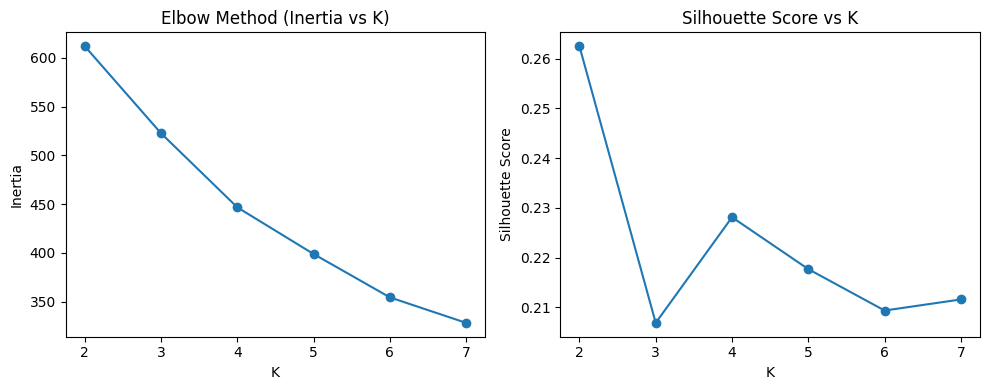


Best K (by Silhouette): 2


In [12]:
# Select features for clustering
features = [
    "delay_rate_15", "delay_rate_60",
    "avg_delay", "p95_delay",
    "carrier_delay_mean", "weather_delay_mean",
    "nas_delay_mean", "late_aircraft_delay_mean",
    "log_flights"
]
X = agg[features].fillna(0)

# Scale features
print("\nFeature snapshot BEFORE scaling:")
display(X.head())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nFeature snapshot AFTER scaling:")
display(pd.DataFrame(X_scaled[:5], columns=features, index=agg.index[:5]))

# Determine optimal number of clusters (K)
inertias, silhouettes = [], []
K_range = range(2, 8)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_range, inertias, marker="o")
plt.title("Elbow Method (Inertia vs K)")
plt.xlabel("K")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K_range, silhouettes, marker="o")
plt.title("Silhouette Score vs K")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

best_k = K_range[np.argmax(silhouettes)]
print(f"\nBest K (by Silhouette): {best_k}")

In [13]:
# Fit final K-Means model
kmeans_final = KMeans(n_clusters=best_k, n_init=20, random_state=42)
labels = kmeans_final.fit_predict(X_scaled)
agg["Cluster"] = labels

# Evaluate clustering
sil = silhouette_score(X_scaled, labels)
dbi = davies_bouldin_score(X_scaled, labels)
print(f"\nSilhouette Score: {sil:.3f}")
print(f"Davies-Bouldin Index: {dbi:.3f}")

# Analyze cluster characteristics
cluster_profiles = agg.groupby("Cluster")[features].mean().sort_values("delay_rate_15", ascending=False)
print("\nCluster profiles (average delay behavior):")
display(cluster_profiles)

# Top airports per cluster
for c in sorted(agg["Cluster"].unique()):
    print(f"\nTop airports in Cluster {c}:")
    display(agg[agg["Cluster"] == c].sort_values("delay_rate_15", ascending=False).head(5))


Silhouette Score: 0.263
Davies-Bouldin Index: 1.409

Cluster profiles (average delay behavior):


,delay_rate_15,delay_rate_60,avg_delay,p95_delay,carrier_delay_mean,weather_delay_mean,nas_delay_mean,late_aircraft_delay_mean,log_flights
Cluster,,,,,,,,,
1,0.230521,0.094611,18.880984,97.185000,6.142487,0.920444,3.051800,7.470763,5.822368
0,0.194852,0.057456,12.825251,66.091071,3.622148,0.806588,1.851003,4.937447,5.600841



Top airports in Cluster 0:


,flights,delay_rate_15,delay_rate_60,avg_delay,p95_delay,carrier_delay_mean,weather_delay_mean,nas_delay_mean,late_aircraft_delay_mean,log_flights,Cluster
Destination Airport,,,,,,,,,,,
OAK,143,0.363636,0.020979,15.916084,49.00,4.559441,0.000000,1.944056,5.797203,4.969813,0
ONT,193,0.259067,0.062176,13.357513,70.60,4.098446,0.051813,1.082902,4.829016,5.267858,0
RNO,181,0.254144,0.060773,14.392265,71.00,2.961326,0.000000,1.276243,7.370166,5.204007,0
DAL,512,0.248047,0.062500,14.904297,69.25,2.369141,0.779297,4.958984,5.099609,6.240276,0
PDX,444,0.231982,0.065315,13.081081,71.85,3.427928,0.189189,2.894144,4.932432,6.098074,0



Top airports in Cluster 1:


,flights,delay_rate_15,delay_rate_60,avg_delay,p95_delay,carrier_delay_mean,weather_delay_mean,nas_delay_mean,late_aircraft_delay_mean,log_flights,Cluster
Destination Airport,,,,,,,,,,,
BUF,111,0.288288,0.108108,18.414414,96.00,7.018018,2.279279,2.441441,6.072072,4.718499,1
BUR,140,0.285714,0.071429,16.685714,90.20,5.857143,0.000000,1.321429,7.085714,4.948760,1
SFO,717,0.270572,0.093445,19.040446,96.80,5.039052,0.249651,4.859135,7.295676,6.576470,1
DFW,1388,0.255043,0.111671,22.992795,132.65,6.653458,1.286023,6.461095,8.763689,7.236339,1
PBI,252,0.253968,0.138889,24.357143,124.80,9.718254,0.305556,5.869048,9.170635,5.533389,1


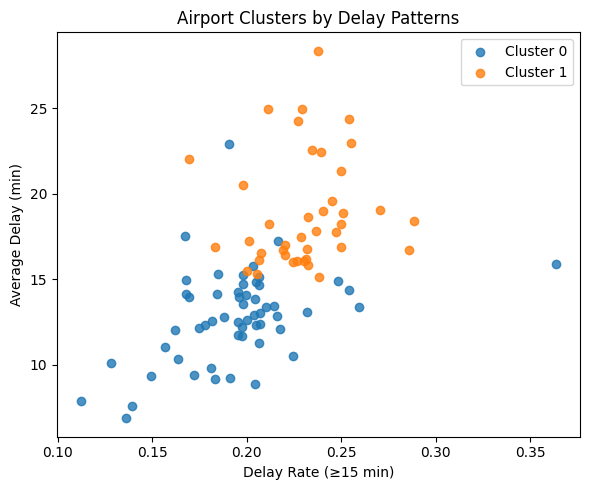


Airport Cluster Assignments:


,Destination Airport,Cluster,delay_rate_15,avg_delay,flights
0,ABQ,0,0.224409,10.515748,254
1,ASE,0,0.190476,22.932540,252
3,ATW,0,0.195489,12.503759,133
4,AUS,0,0.198148,14.727778,540
6,BNA,0,0.177955,12.328021,753
...,...,...,...,...,...
83,SFO,1,0.270572,19.040446,717
91,TPA,1,0.228856,17.459370,603
89,SRQ,1,0.227273,24.290909,110
93,TUS,1,0.251101,18.863436,227


In [14]:
# Visualization
plt.figure(figsize=(6,5))
for c in sorted(agg["Cluster"].unique()):
    sub = agg[agg["Cluster"] == c]
    plt.scatter(sub["delay_rate_15"], sub["avg_delay"], label=f"Cluster {c}", alpha=0.8)
plt.xlabel("Delay Rate (≥15 min)")
plt.ylabel("Average Delay (min)")
plt.title("Airport Clusters by Delay Patterns")
plt.legend()
plt.tight_layout()
plt.show()

# Final airport-cluster assignments
agg.reset_index(inplace=True)
print("\nAirport Cluster Assignments:")
display(agg[[airport_col, "Cluster", "delay_rate_15", "avg_delay", "flights"]].sort_values("Cluster"))

# K-Means Clustering: Airport Delay Patterns

**Why the model was chosen:** K-Means clustering was selected to identify groups of airports that share similar delay characteristics like frequency, duration, and underlying causes. K-Means is an appropriate unsupervised algorithm to detect groupings without predefined labels because the dataset include continuous numeric features like average delay minutes and percentage of flights delayed. This method helps highlight airports with consistently higher delay rates compared to those operating more efficiently.

**Model assumptions:** K-Means requires numerical features on a comparable scale, so all inputs were standardized before clustering. This ensures Euclidean distance reflects true similarity between airlines rather than differences in variable magnitude, allowing the model to form meaningful groups.

**Hyperparameter tuning:** Hyperparameter tuning was conducted using both the Elbow Method and the Silhouette Score to determine the optimal number of clusters. The Elbow curve showed diminishing gains in inertia beyond K = 2, and the Silhouette curve also peaked at K = 2 with a value of 0.263. Based on these results, the final model parameters were set to n_clusters = 2, n_init = 20, and random_state = 42. The evaluation metrics (Silhouette = 0.263 and Davies–Bouldin = 1.409) indicate moderate separation between clusters, which is reasonable for real-world transportation data where delay patterns naturally overlap.

**Challenges faced & solutions:** Several preprocessing challenges were addressed to ensure meaningful clustering. First, uneven flight volumes meant large hubs could dominate delay statistics, so a log-transformed flight count feature (log_flights) was added to balance scale differences. Second, airports with very few observations introduced noise, so locations with fewer than 100 flights were removed. Finally, extreme delay events and multiple overlapping delay causes inflated averages, so the 95th-percentile delay (p95_delay) and averaged cause-specific delay measures were used to stabilize the inputs and reduce the influence of outliers.

**Data Preparation:** To prepare the data for K-Means clustering, flight-level records were cleaned and aggregated into airport-level metrics. Delay fields were converted to numeric format and negative delays were clipped to zero. New features were engineered, including delay rates (≥15 and ≥60 minutes), mean delay duration, 95th-percentile delay, and average delay by cause. Airports with fewer than 100 flights were removed to reduce noise. Finally, all selected features were standardized so they contributed equally to Euclidean distance, and the resulting scaled feature matrix was used as input for clustering.

**Key Findings:** The clustering results revealed two distinct airport performance groups. Cluster 0 represents lower-delay airports, with moderate delay rates of about 19 percent and shorter average delays of about 13 minutes, including PDX, DAL, RNO, OAK, and ONT. Cluster 1 reflects higher-delay airports, with delay rates of about 23 percent and average delays of about 19 minutes, such as DFW, SFO, BUF, and PBI. Overall, the results show that major hub airports tend to experience more frequent and longer delays due to congestion and complex operations, while regional airports generally maintain more efficient turnaround times.

**Performance and Evalaution:** The K-Means clustering model performed reliably in separating airports into two delay-behavior groups. With K = 2, the model achieved a Silhouette Score of 0.263 and a Davies-Bouldin score of 1.409, indicating moderate separation between clusters. Despite natural noise in transportation systems, the model was still able to differentiate airports with consistently low delays from those with frequent and longer disruptions, demonstrating that K-Means was effective for uncovering patterns in airport delay performance.

# Model #9 - (Question # 9) - Frequent Pattern Mining – Apriori Research Question: “Do flights to or from certain locations or at certain times tend to be delayed more?”

In [15]:
# Apriori Model – Finding Delay Association Rules
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# 1. Load dataset
path = "/content/AllData_Mergedfinal.csv"
df = pd.read_csv(path)

print("Shape:", df.shape)
df.head()

Shape: (43853, 21)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,Carrier Code,Date (MM/DD/YYYY),Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),...,Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes),Delay Unknown (Minutes),Arrival Delay (Minutes),Total Delay (Minutes),Num of Delay Reasons,Primary Delay Reason,Primary Delay Percentage
0,B6,01/12/2024,JFK,17:50,18:08,164.0,212.0,18.0,19:14,66.0,...,18.0,48.0,0.0,0.0,0.0,48.0,66.0,2,Aviation System,0.727273
1,B6,01/24/2024,JFK,17:50,17:36,164.0,161.0,-14.0,17:48,12.0,...,0.0,0.0,0.0,0.0,0.0,-3.0,-17.0,0,No Reason,0.000000
2,B6,02/12/2024,JFK,17:50,00:00,164.0,0.0,0.0,00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,-164.0,-164.0,0,No Reason,0.000000
3,B6,02/24/2024,JFK,16:43,16:35,166.0,171.0,-8.0,16:51,16.0,...,0.0,0.0,0.0,0.0,0.0,5.0,-3.0,0,No Reason,0.000000
4,B6,03/12/2024,JFK,16:56,17:09,169.0,164.0,13.0,17:22,13.0,...,0.0,0.0,0.0,0.0,8.0,-5.0,8.0,1,Unknown,1.000000


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [16]:
# Data Preprocessing
# Convert delay minutes to numeric
df["Departure delay (Minutes)"] = pd.to_numeric(df["Departure delay (Minutes)"], errors="coerce")
df["Arrival Delay (Minutes)"] = pd.to_numeric(df["Arrival Delay (Minutes)"], errors="coerce")

# Define delay status
df["Is_Delayed"] = (df["Departure delay (Minutes)"] >= 15).astype(int)

# Extract hour from departure time
def extract_hour(t):
    try:
        return int(t.split(":")[0])
    except:
        return None

df["DepHour"] = df["Scheduled departure time"].astype(str).apply(extract_hour)

# Categorize into time windows
def time_window(hour):
    if pd.isna(hour):
        return "Unknown"
    elif 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Late Night"

df["TimeOfDay"] = df["DepHour"].apply(time_window)

# Simplify categorical features
df["Destination Airport"] = df["Destination Airport"].astype(str)
df["Carrier Code"] = df["Carrier Code"].astype(str)

# Keep relevant columns
subset = df[["Carrier Code", "Destination Airport", "TimeOfDay", "Is_Delayed"]].copy()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [17]:
# Encode data for Apriori
# Create transactions: one-hot encoding
transactions = pd.get_dummies(subset[["Carrier Code", "Destination Airport", "TimeOfDay"]])

# Add delay flag
transactions["Delayed"] = subset["Is_Delayed"]

print("Transactions shape:", transactions.shape)
transactions.head()

# Apply Apriori algorithm
# Frequent itemsets (support threshold = 0.05 = appears in at least 5% of records)
frequent_itemsets = apriori(transactions, min_support=0.05, use_colnames=True)
print(f"\nFound {len(frequent_itemsets)} frequent itemsets.")
frequent_itemsets.sort_values("support", ascending=False).head(10)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Transactions shape: (43853, 223)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


Found 23 frequent itemsets.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,support,itemsets
7,0.40768,(TimeOfDay_Morning)
3,0.304928,(Carrier Code_UA)
5,0.274531,(TimeOfDay_Afternoon)
6,0.270723,(TimeOfDay_Evening)
8,0.209564,(Delayed)
4,0.206371,(Carrier Code_WN)
2,0.177685,(Carrier Code_OO)
15,0.127015,"(TimeOfDay_Morning, Carrier Code_UA)"
0,0.123093,(Carrier Code_AA)
14,0.092833,"(TimeOfDay_Evening, Carrier Code_UA)"


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [18]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Filter for rules that predict delays
rules_delay = rules[rules["consequents"].apply(lambda x: "Delayed" in x)]

# Sort by confidence
rules_delay = rules_delay.sort_values("confidence", ascending=False)

print("\nTop 10 Delay Association Rules:")
display(rules_delay.head(10)[["antecedents", "consequents", "support", "confidence", "lift"]])


Top 10 Delay Association Rules:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,antecedents,consequents,support,confidence,lift
16,(TimeOfDay_Evening),(Delayed),0.075913,0.280408,1.338054
13,(Carrier Code_WN),(Delayed),0.050441,0.244420,1.166327
14,(TimeOfDay_Afternoon),(Delayed),0.065742,0.239472,1.142715


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [19]:

# Simplified readable format
def clean_rule(rule):
    return ", ".join(list(rule)).replace("_", " ")

top_rules = rules_delay.head(10).copy()
top_rules["Rule"] = top_rules["antecedents"].apply(clean_rule) + " → " + top_rules["consequents"].apply(clean_rule)

top_rules[["Rule", "support", "confidence", "lift"]]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,Rule,support,confidence,lift
16,TimeOfDay Evening → Delayed,0.075913,0.280408,1.338054
13,Carrier Code WN → Delayed,0.050441,0.244420,1.166327
14,TimeOfDay Afternoon → Delayed,0.065742,0.239472,1.142715


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

# Frequent Pattern Mining — Apriori (Delay Associations)

**Why this model was chosen:** Apriori was applied to uncover interpretable co-occurrence patterns between categorical flight attributes and delay outcomes. The dataset of 43,853 records was well suited for a transactional format after converting departure times into time-of-day categories and one-hot encoding carrier and airport identifiers. The resulting association rules highlight clear and actionable patterns, such as certain times of day or airport characteristics that frequently co-occur with delayed departures. These insights provide an explainable layer of understanding that complements predictive modeling by identifying when and where delays are most likely to occur.

**Model assumptions:** The Apriori model was applied to a one-hot encoded transaction matrix containing 43,853 rows and 223 binary indicator columns. Each item is treated as an independent categorical feature, and associations are evaluated using support, confidence, and lift. The dataset produced frequent co-occurring patterns that surpassed the minimum support threshold, making it suitable for discovering meaningful relationships related to flight delays.

**Data Preparation:** To prepare the dataset for Apriori association mining, flight-level records were first cleaned and transformed into a transaction format. Departure and arrival delay fields were converted from string values to numeric, and a binary Is_Delayed flag was created to identify departures delayed by 15 minutes or more. The scheduled departure time was parsed to extract the hour of day and then bucketed into four interpretable time windows, Morning, Afternoon, Evening, and Late Night, to standardize temporal categories across flights. Categorical fields such as Carrier Code and Destination Airport were cast to string to ensure consistent encoding. A subset of relevant features (carrier, airport, time-of-day, and delay outcome) was used to generate the transaction matrix via one-hot encoding, resulting in a wide binary dataset where each column represents the presence of a category for a given flight.

**Hyperparameter tuning:** Hyperparameter tuning for Apriori used a minimum support of 0.05 to retain patterns appearing in at least 5 percent of flights, which produced 23 frequent itemsets while reducing noise. Association rules were evaluated using lift with a minimum threshold of 1.0 to ensure relationships were stronger than chance, and results were filtered to retain only rules that predicted delays. The strongest rules showed that evening departures, certain carriers, and afternoon flights were more likely to result in delays, with lift values above 1 indicating a 14 to 34 percent higher likelihood of delay compared to the baseline rate.

**Challenges & solutions:** Several preprocessing issues needed to be addressed to obtain meaningful Apriori rules. The one-hot encoded transaction matrix contained 223 columns, which increased computation time and diluted support, so a minimum support of 0.05 was used to retain only meaningful patterns. Because most flights are not delayed, many trivial rules tended to predict “not delayed,” so rules were filtered to keep only those with “Delayed” as the consequent and then ranked by lift. Mixed column types initially triggered warnings and slowed execution, so the matrix was cast to boolean format to speed up mining. Finally, variability in scheduled-time strings was handled by extracting the hour and binning flights into time-of-day categories to create consistent inputs for association discovery.

**Perfromance and Evalaution:** Apriori revealed clear and interpretable patterns showing that evening flights, and to a lesser extent afternoon flights, along with certain carrier contexts, are associated with a higher likelihood of delays. These results provide insight that can support scheduling decisions, improve passenger communication, and guide staffing allocation during higher risk time periods.